# Spádové metody pro hledání lokálních extrémů
*Tomáš Kalvoda, KAM FIT ČVUT, 2015*

In [ ]:
# pokud tento notebook používáte v SageMathCloud
%load_ext sage

Při iterování budeme potřebovat algoritmus zpětného krokování (*backtrack*) popsaný na přednášce.

In [1]:
def backtrack(f, gradfx, x, dx, t=1., alpha=0.3, beta=0.7):
    while f(x + t*dx) > f(x) + alpha*t*gradfx*dx:
        t *= beta
    return t

## Gradientová metoda

Gradientová metoda, jak už název napovídá, v každém kroce z bodu $x$ volí směr poklesu $-\nabla f(x)$. Tento směr minimalizuje $\{ \nabla f(x) \cdot v \mid \|v\| \leq 1 \}$ vzhledem k Euklidovské normě.

## Příklad č. 1

Pro začátek uvažme kvadratickou funkci $(x,y) \mapsto x^2 + 4y^2$.

In [3]:
def f(x):
    return x[0]^2 + 4*x[1]^2

def gradf(x):
    return vector([2*x[0], 8*x[1]])

Znázornění jejích kontur.

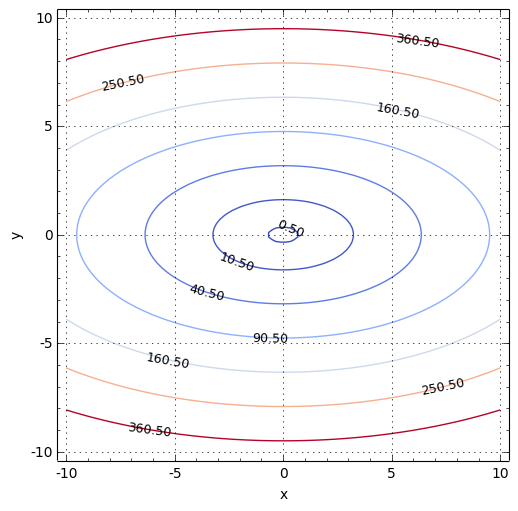

In [4]:
figc = contour_plot(lambda x,y: f([x,y]), (-10,10), (-10,10),
             axes_labels=['x','y'], fill=False, cmap='coolwarm',
             contours=[0.5+10*t^2 for t in range(7)],
             gridlines=True, labels=True, label_colors='black'
            )
show(figc, figsize=7)

Rutina počítající iterace spádové metody do té doby, doku gradient funkce není prakticky nulový (vzhledem k předepsané toleranci).

In [5]:
def grad_desc(f, gradf, x, tol=1e-6):
    output = [x]
    while norm(gradf(x)) > tol:
        x += -backtrack(f, gradf(x), x, -gradf(x))*gradf(x)
        output.append(x)
    return output

Vlastní výpočet iterací.

In [6]:
aps = grad_desc(f, gradf, vector([8,9]))
print "Počet iterací: ", len(aps)
print "Poslední iterace: ", aps[-1]

Počet iterací:  33
Poslední iterace:  (2.49475564829296e-7, 6.72366299598247e-8)


Znázornění kroků iterace. Vidíme, že gradientová metoda v tomto případě není příliš přímočará.

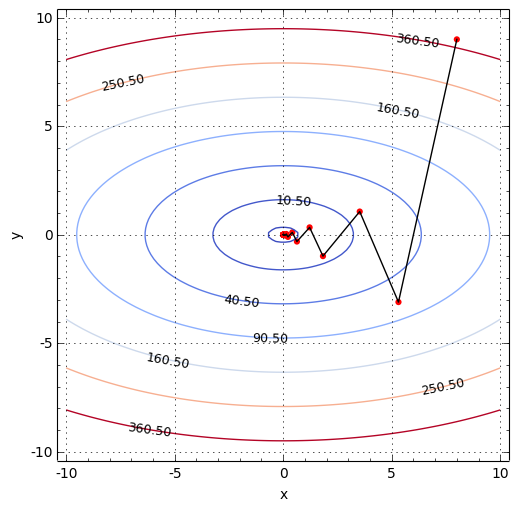

In [6]:
figps = points(aps, color='red', size=20) + line2d(aps, color='black')
show(figps + figc, figsize=7)

Znázornění vývoje chyby funkční hodnoty při iteraci gradientovou metodou. V logaritmické škále se tato metoda chová lineárně.

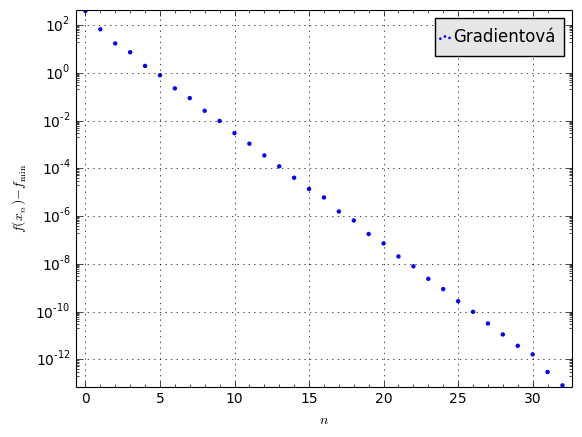

In [95]:
list_plot_semilogy(map(f, aps), frame=True, figsize=6, gridlines=True,
                   axes_labels=['$n$',r'$f(x_n) - f_\min$'], legend_label=u'Gradientová'
                  )

## Příklad č. 2

Uvažme komplikovanější nelineární funkci dvou proměnných.

In [7]:
def f(x):
    return exp(x[0] + 3*x[1] - 0.1) + exp(x[0] - 3*x[1] - 0.1) + exp(-x[0] - 0.1)

def gradf(x):
    return vector([
            exp(x[0] + 3*x[1] - 0.1) + exp(x[0] - 3*x[1] - 0.1) - exp(-x[0] - 0.1),
            3*exp(x[0] + 3*x[1] - 0.1) -3*exp(x[0] - 3*x[1] - 0.1)])

def hessf(x):
    return matrix([
            [exp(x[0] + 3*x[1] - 0.1) + exp(x[0] - 3*x[1] - 0.1) + exp(-x[0] - 0.1), 3*exp(x[0] + 3*x[1] - 0.1) -3*exp(x[0] - 3*x[1] - 0.1)],
            [3*exp(x[0] + 3*x[1] - 0.1) -3*exp(x[0] - 3*x[1] - 0.1), 9*exp(x[0] + 3*x[1] - 0.1) +9*exp(x[0] - 3*x[1] - 0.1)]
            ])

Znázornění jejích kontur.

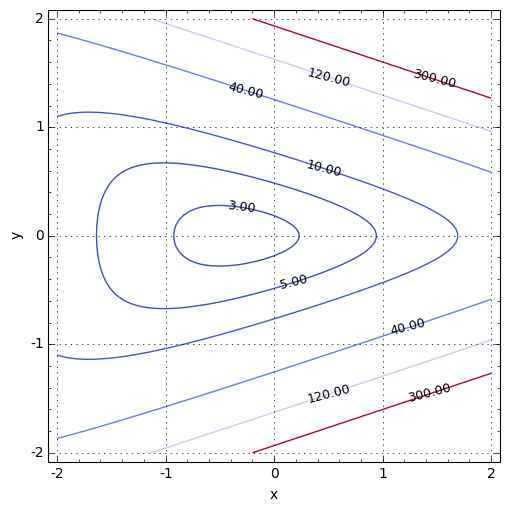

In [8]:
figc = contour_plot(lambda x,y: f([x,y]), (-2,2), (-2,2),
             axes_labels=['x','y'], fill=False, cmap='coolwarm',
             contours=[3, 5, 10, 40, 120, 300],
             gridlines=True, labels=True, label_colors='black'
            )
show(figc, figsize=7)

Vlastní iterace.

In [9]:
aps1 = grad_desc(f, gradf, vector([1.8,-1.8]))
print "Počet iterací: ", len(aps1)
print "Poslední iterace: ", aps1[-1]

Počet iterací:  38
Poslední iterace:  (-0.346573308967668, 4.50890796720556e-8)


I v tomto případě u iterací pozorujeme podobné chování jako dříve.

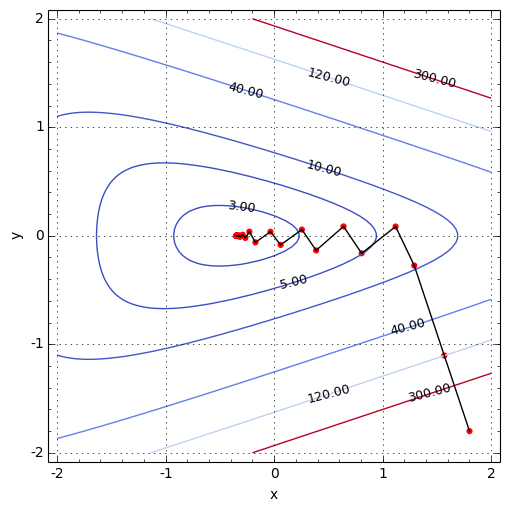

In [10]:
figps = points(aps1, color='red', size=20) + line2d(aps1, color='black')
show(figps + figc, figsize=7)

Taktéž chyba vykazuje podobné chování.

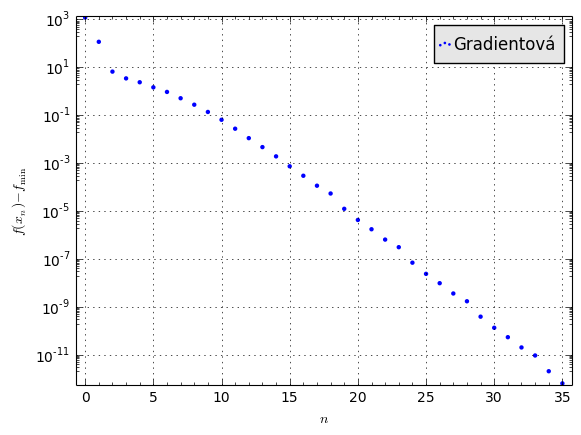

In [11]:
errs = map(lambda x: f(x) - f(aps1[-1]), aps1[0:-2])
figerrs1 = list_plot_semilogy(errs, frame=True, gridlines=True,
                   axes_labels=['$n$',r'$f(x_n) - f_\min$'], legend_label=u'Gradientová'
                  )
show(figerrs1, figsize=6)

## Newtonova metoda

Pokusme se na předchozí příklad použít Newtonovu metodu. Ta v každém bodě $x$ volí směr poklesu $-(\nabla^2 f(x))^{-1} \nabla f(x)$, který minimalizuje $\{ \nabla f(x) \cdot v \mid \|v\|\}$ vzhledem k normě $v \mapsto \sqrt{v^T \nabla^2 f(x) v}$, samozřejmě za předpokladu, že Hessova matice funkce $f$ v bodě $x$ je symmetrická a pozitivně definitiní matice.

Hrubě řečeno, tento směr bere do úvahy nejen *sklon* grafu funkce v bodě $x$, ale i její *křivost*.

In [12]:
def newt_desc(f, gradf, hessf, x, tol=1e-6):
    output = [x]
    while norm(gradf(x)) > tol:
        gradfx = gradf(x)
        dx = -hessf(x).inverse()*gradfx
        x += backtrack(f, gradfx, x, dx)*dx
        output.append(x)
    return output

Vlastní iterace. Povšimněte si, že jsme museli podstatně zvýšit přesnost, abychom dostali dostatek bodů k porovnání s gradientovou metodou (jinak by Newtonova metoda velmi rychle ukončila běh, i tak ale máme podstatně méně iterací).

In [13]:
aps2 = newt_desc(f, gradf, hessf, vector([1.8,-1.8]), tol=1e-12)
print "Počet iterací: ", len(aps2)
print "Poslední iterace: ", aps2[-1]

Počet iterací:  13
Poslední iterace:  (-0.346573590279973, -7.47799072186398e-18)


Znázornění iterací Newtonovy metody.

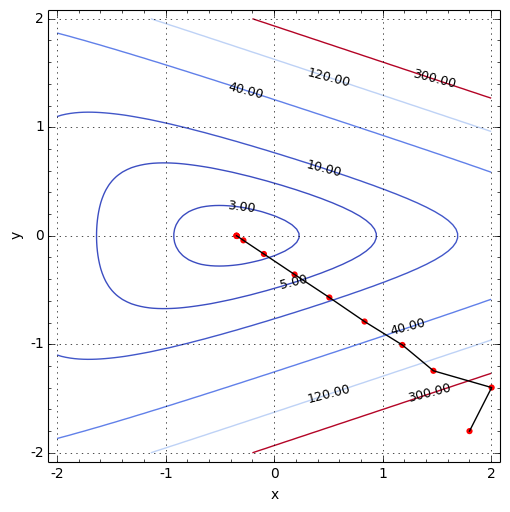

In [14]:
figps = points(aps2, color='red', size=20) + line2d(aps2, color='black')
show(figps + figc, figsize=7)

Porovnání rychlosti konvergence Newtonovy a gradientové metody.

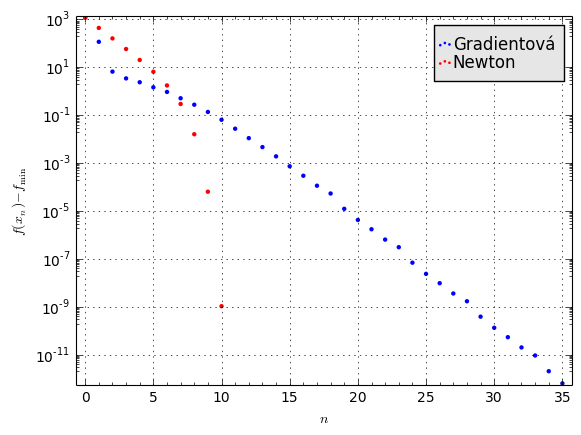

In [107]:
errs = map(lambda x: f(x) - f(aps2[-1]), aps2[0:-2])
figerrs2 = list_plot_semilogy(errs, frame=True, gridlines=True,
                   axes_labels=['$n$',r'$f(x_n) - f_\min$'], legend_label=u'Newton', color='red'
                  )
show(figerrs1+figerrs2, figsize=6)